# Regression Model

We've cleaned the data, made some observations about it, and ran statistical tests on it. Now we want to know, how well can we predict a student's reading score based on these features?

## Import Packages and Read in Data

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import preprocessing
from statsmodels.formula.api import ols
import re
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn import linear_model

In [2]:
df = pd.read_csv('../Data/clean_data.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,grade,male,preschool,expectBachelors,motherHS,motherWork,fatherHS,fatherWork,selfBornUS,motherBornUS,fatherBornUS,englishAtHome,computerForSchoolwork,read30MinsADay,minutesPerWeekEnglish,studentsInEnglish,schoolHasLibrary,publicSchool,urban,schoolSize,readingScore,American Indian/Alaska Native,Asian,Black,Hispanic,More than one race,Native Hawaiian/Other Pacific Islander,White
0,9,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,250.0,28.0,1.0,1,0,1233.0,554.81,0,0,0,0,0,0,1
1,10,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,200.0,23.0,1.0,1,1,2640.0,458.11,0,0,1,0,0,0,0
2,10,1,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,250.0,35.0,1.0,1,1,1095.0,613.89,0,0,0,1,0,0,0
3,10,0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,300.0,30.0,1.0,1,0,1913.0,439.36,0,0,0,0,0,0,1
4,9,0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,378.0,20.0,0.0,1,1,502.0,428.96,0,0,0,0,0,0,1


We can now make a new dataframe listing only our target column, and start a list of columns we will want dropped from our feature dataframe.

In [3]:
target = pd.DataFrame(df['readingScore'])
dropped_col = ['readingScore']

## Checking for Multicollinearity

In [4]:
abs(df.corr()) > 0.75

,grade,male,preschool,expectBachelors,motherHS,motherWork,fatherHS,fatherWork,selfBornUS,motherBornUS,fatherBornUS,englishAtHome,computerForSchoolwork,read30MinsADay,minutesPerWeekEnglish,studentsInEnglish,schoolHasLibrary,publicSchool,urban,schoolSize,readingScore,American Indian/Alaska Native,Asian,Black,Hispanic,More than one race,Native Hawaiian/Other Pacific Islander,White
grade,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
male,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
preschool,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
expectBachelors,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
motherHS,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
motherWork,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
fatherHS,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
fatherWork,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
selfBornUS,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
motherBornUS,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Variables with high multicollinearity:
* `motherBornUS` and `fatherBornUS`

We'll need to remove one of these features from our model function. Let's look at just the correlation values for these features and the target.

In [5]:
corr_df = df[['motherBornUS','fatherBornUS', 'readingScore']]
corr_df.corr()

,motherBornUS,fatherBornUS,readingScore
motherBornUS,1.000000,0.766484,0.061823
fatherBornUS,0.766484,1.000000,0.073537
readingScore,0.061823,0.073537,1.000000


Since `motherBornUS` has a smaller correlation with `readingScore`, we'll choose to remove that one.

In [6]:
dropped_col.append('motherBornUS')

When we cleaned our data, we made the `raceeth` column into dummy variables. To reduce multicollinearity and avoid redundancy, we will have to remove one of these columns. Again, we look at just the correlation values for these features and the target.

In [7]:
corr_df = df[['American Indian/Alaska Native','Asian','Black','Hispanic','More than one race','Native Hawaiian/Other Pacific Islander','White','readingScore']]
corr_df.corr()

,American Indian/Alaska Native,Asian,Black,Hispanic,More than one race,Native Hawaiian/Other Pacific Islander,White,readingScore
American Indian/Alaska Native,1.000000,-0.018465,-0.025362,-0.042217,-0.016061,-0.007773,-0.113852,-0.085653
Asian,-0.018465,1.000000,-0.062833,-0.104592,-0.039789,-0.019257,-0.282064,0.064128
Black,-0.025362,-0.062833,1.000000,-0.143661,-0.054652,-0.026450,-0.387426,-0.182196
Hispanic,-0.042217,-0.104592,-0.143661,1.000000,-0.090975,-0.044029,-0.644913,-0.172303
More than one race,-0.016061,-0.039789,-0.054652,-0.090975,1.000000,-0.016750,-0.245341,-0.009069
Native Hawaiian/Other Pacific Islander,-0.007773,-0.019257,-0.026450,-0.044029,-0.016750,1.000000,-0.118738,0.000865
White,-0.113852,-0.282064,-0.387426,-0.644913,-0.245341,-0.118738,1.000000,0.234807
readingScore,-0.085653,0.064128,-0.182196,-0.172303,-0.009069,0.000865,0.234807,1.000000


`Native Hawaiian/Other Pacific Islander` has the smallest correlation with our target variable, so we will remove that from our features.

In [8]:
dropped_col.append('Native Hawaiian/Other Pacific Islander')

## Visualizing Features

When cleaning our data, we saw there were three continuous variables.
* minutesPerWeekEnglish
* studentsInEnglish
* schoolSize

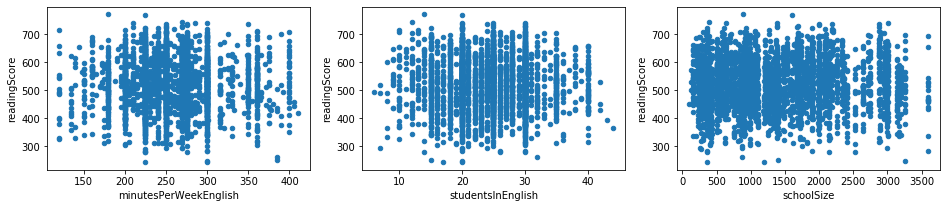

In [9]:
continuous = ['minutesPerWeekEnglish','studentsInEnglish','schoolSize']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(continuous, axes):
    df.plot.scatter(x=xcol,y='readingScore', ax=ax)

It looks like none of these variables are linear. Our polynomial model should help account for this.

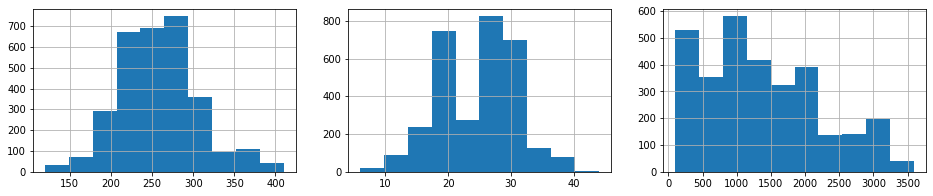

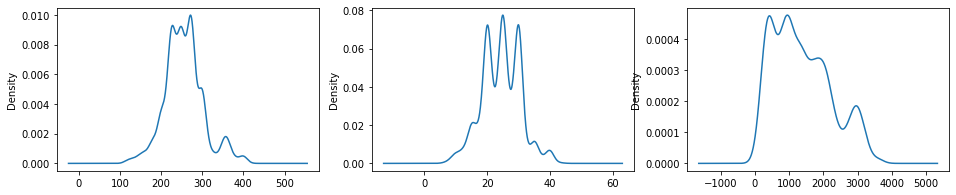

In [10]:
continuous = ['minutesPerWeekEnglish','studentsInEnglish','schoolSize']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(continuous, axes):
    df[xcol].hist(ax=ax)
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(continuous, axes):
    df[xcol].plot.kde(ax=ax)

We can see that these are non-normal distributions.

## Split Data into Training and Testing

In [11]:
features = df.drop(columns=dropped_col).copy()
features.head()

,grade,male,preschool,expectBachelors,motherHS,motherWork,fatherHS,fatherWork,selfBornUS,fatherBornUS,englishAtHome,computerForSchoolwork,read30MinsADay,minutesPerWeekEnglish,studentsInEnglish,schoolHasLibrary,publicSchool,urban,schoolSize,American Indian/Alaska Native,Asian,Black,Hispanic,More than one race,White
0,9,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,250.0,28.0,1.0,1,0,1233.0,0,0,0,0,0,1
1,10,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,200.0,23.0,1.0,1,1,2640.0,0,0,1,0,0,0
2,10,1,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,250.0,35.0,1.0,1,1,1095.0,0,0,0,1,0,0
3,10,0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,300.0,30.0,1.0,1,0,1913.0,0,0,0,0,0,1
4,9,0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,378.0,20.0,0.0,1,1,502.0,0,0,0,0,0,1


In [12]:
#create a train and test set
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=23,test_size=0.2)
#create a validation set from training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=23,test_size=0.2)

#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Testing set - Features: ", X_test.shape, "Target: ",y_test.shape)
print("Validation set - Features: ", X_val.shape, "Target: ",y_val.shape)

Training set - Features:  (1989, 25) Target:  (1989, 1)
Testing set - Features:  (622, 25) Target:  (622, 1)
Validation set - Features:  (498, 25) Target:  (498, 1)


## Standardization

Before creating a model, we want to normalize our data.

In [13]:
scaler = preprocessing.StandardScaler()

for var in continuous:
    # create a scaler from the training set
    scaler.fit(X_train[[var]])
    # transform training, validation, and testing set with this scalar
    X_train[var+'_scaled'] = scaler.transform(X_train[[var]])
    X_val[var+'_scaled'] = scaler.transform(X_val[[var]])
    X_test[var+'_scaled'] = scaler.transform(X_test[[var]])
    
# drop original columns
X_train.drop(columns=continuous,inplace=True)    
X_val.drop(columns=continuous,inplace=True)
X_test.drop(columns=continuous,inplace=True)

/Users/GabbaFlabba/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/GabbaFlabba/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/GabbaFlabba/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

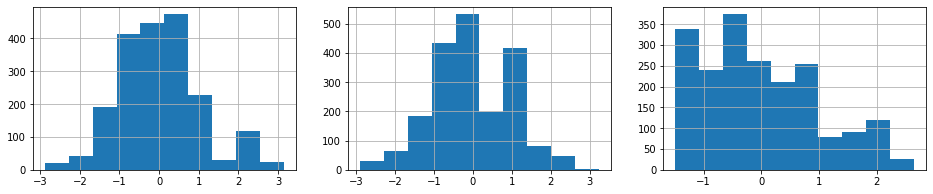

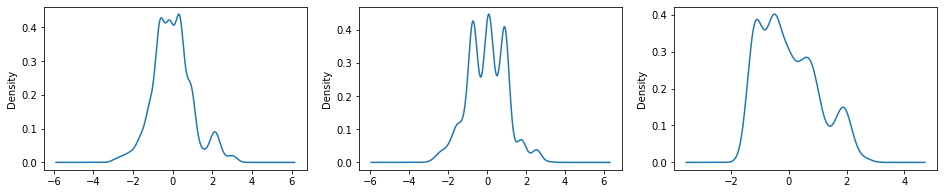

In [14]:
continuous = ['minutesPerWeekEnglish_scaled','studentsInEnglish_scaled','schoolSize_scaled']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(continuous, axes):
    X_train[xcol].hist(ax=ax)
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(continuous, axes):
    X_train[xcol].plot.kde(ax=ax)

## Modeling

### OLS Model - 1

Now we are ready to build our first linear model.

Let's first define a function which makes sure all column names have no special characters or whitespace.

In [15]:
def fix_names(data):
    """Fix column names in data so that they can be parsed by the OLS formula."""
    for name in data.columns:
        fixed_name = re.sub(r"[^a-zA-Z0-9]+", '', name)
        data = data.rename(columns={name: fixed_name}).copy()
    return data

In [16]:
X_train = fix_names(X_train)
X_val = fix_names(X_val)
X_test = fix_names(X_test)

In [17]:
continuous = [re.sub(r"[^a-zA-Z0-9]+", '', x) for x in continuous]

Now that the columns names are in a standard format, let's define a function which creates our formula string for us based off of column names.

In [18]:
def build_formula(target,features,continuous):
    """Return formula string for given target and feature dataframes."""
    formula = f"{target.columns[0]}~"
    i = 0
    for name in features.columns:
        if i == 0:
            if name not in continuous:
                formula += f"C({name})"
            else:
                formula += name
            i = 1
        else:
            if name not in continuous:
                formula += f"+C({name})"
            else:
                formula += f"+{name}"
    return formula

Now we can use this function in all our OLS formulas by inputting a dataframe which contains only the columns we want included in the model.

In [19]:
first_model = ols(formula=build_formula(y_train,X_train,continuous), data=pd.concat([X_train,y_train],axis=1)).fit()
first_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           readingScore   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     26.05
Date:                Fri, 27 Mar 2020   Prob (F-statistic):          1.41e-113
Time:                        09:23:36   Log-Likelihood:                -11424.
No. Observations:                1989   AIC:                         2.291e+04
Df Residuals:                    1960   BIC:                         2.307e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                            332.0927     81.251      4.087      0.000     172.745     491.440
C(grade)[T.9]                         82.7972     76.594      1.081      0.280     -67.417     233.011
C(grade)[T.10]                       129.5062     76.313      1.697      0.090     -20.157     279.169
C(grade)[T.11]                       147.2550     76.389      1.928      0.054      -2.556     297.066
C(grade)[T.12]                       114.3239    108.027      1.058      0.290     -97.536     326.183
C(male)[T.1]                          -9.8114      3.546     -2.767      0.006     -16.766      -2.856
C(preschool)[T.1.0]                    0.7834      4.014      0.195      0.845      -7.088       8.655
C(expectBachelors)[T.1.0]             55.9812      4.806     11.648      0.000      46.556      65.406
C(motherHS)[T.1.0]                     9.9558      7.129      1.397      0.163      -4.025      23.937
C(motherWork)[T.1.0]                  -1.2481      4.052     -0.308      0.758      -9.194       6.698
C(fatherHS)[T.1.0]                     7.7283      6.617      1.168      0.243      -5.249      20.706
C(fatherWork)[T.1.0]                   5.1911      5.045      1.029      0.304      -4.704      15.086
C(selfBornUS)[T.1.0]                  -2.0739      8.312     -0.250      0.803     -18.375      14.227
C(fatherBornUS)[T.1.0]                -1.9187      6.266     -0.306      0.759     -14.208      10.370
C(englishAtHome)[T.1.0]               14.9935      7.658      1.958      0.050      -0.025      30.012
C(computerForSchoolwork)[T.1.0]       16.1175      7.215      2.234      0.026       1.968      30.267
C(read30MinsADay)[T.1.0]              34.9007      3.866      9.028      0.000      27.319      42.482
C(schoolHasLibrary)[T.1.0]           -16.1953     10.705     -1.513      0.130     -37.191       4.800
C(publicSchool)[T.1]                 -22.6949      7.104     -3.195      0.001     -36.626      -8.763
C(urban)[T.1]                         -4.2390      4.404     -0.963      0.336     -12.876       4.398
C(AmericanIndianAlaskaNative)[T.1]   -63.1791     29.393     -2.149      0.032    -120.824      -5.534
C(Asian)[T.1]                         15.7285     22.912      0.686      0.492     -29.205      60.662
C(Black)[T.1]                        -51.2363     22.324     -2.295      0.022     -95.017      -7.456
C(Hispanic)[T.1]                     -20.9075     21.736     -0.962      0.336     -63.536      21.721
C(Morethanonerace)[T.1]                2.6987     23.255      0.116      0.908     -42.908      48.306
C(White)[T.1]                         17.1682     21.621      0.794      0.427     -25.235      59.571
minutesPerWeekEnglishscaled            0.8157      1.780      0.458      0.647      -2.676      

In [20]:
print(f"Training Data RMSE: {math.sqrt(mean_squared_error(y_train,first_model.predict(X_train)))}")
      
print(f"Validation Data RMSE: {math.sqrt(mean_squared_error(y_val,first_model.predict(X_val)))}")
      

Training Data RMSE: 75.5491592862352
Validation Data RMSE: 70.27194008392037


### OLS Model - 2

We can see that this model is not very useful. Many features have a high p-value, and our R squared is low. Let's try removing variables with a P-value higher than 0.5. 
These are:
* `preschool`
* `motherWork`
* `selfBornUS`
* `fatherBornUS`
* `Morethanonerace`
* `minutesPerWeekEnglishscaled`

In [21]:
X_train_2 = X_train.drop(columns=['preschool','motherWork','selfBornUS','fatherBornUS','Morethanonerace','minutesPerWeekEnglishscaled']).copy()

In [22]:
second_model = ols(formula=build_formula(y_train,X_train_2,continuous), data=pd.concat([X_train,y_train],axis=1)).fit()
second_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           readingScore   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     33.22
Date:                Fri, 27 Mar 2020   Prob (F-statistic):          6.26e-118
Time:                        09:23:36   Log-Likelihood:                -11425.
No. Observations:                1989   AIC:                         2.290e+04
Df Residuals:                    1966   BIC:                         2.302e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                            331.2488     78.684      4.210      0.000     176.936     485.561
C(grade)[T.9]                         83.6434     76.428      1.094      0.274     -66.244     233.531
C(grade)[T.10]                       130.3396     76.138      1.712      0.087     -18.979     279.658
C(grade)[T.11]                       148.0814     76.220      1.943      0.052      -1.399     297.562
C(grade)[T.12]                       116.6194    107.727      1.083      0.279     -94.652     327.891
C(male)[T.1]                          -9.8831      3.535     -2.796      0.005     -16.815      -2.951
C(expectBachelors)[T.1.0]             56.1199      4.786     11.725      0.000      46.733      65.507
C(motherHS)[T.1.0]                     9.8049      7.079      1.385      0.166      -4.078      23.688
C(fatherHS)[T.1.0]                     7.4356      6.561      1.133      0.257      -5.432      20.303
C(fatherWork)[T.1.0]                   5.3111      5.008      1.060      0.289      -4.511      15.133
C(englishAtHome)[T.1.0]               13.3860      6.670      2.007      0.045       0.306      26.466
C(computerForSchoolwork)[T.1.0]       16.3276      7.162      2.280      0.023       2.281      30.374
C(read30MinsADay)[T.1.0]              35.0435      3.847      9.109      0.000      27.499      42.588
C(schoolHasLibrary)[T.1.0]           -16.2962     10.668     -1.528      0.127     -37.218       4.626
C(publicSchool)[T.1]                 -22.5814      6.986     -3.232      0.001     -36.283      -8.880
C(urban)[T.1]                         -4.3599      4.387     -0.994      0.320     -12.964       4.244
C(AmericanIndianAlaskaNative)[T.1]   -65.4335     21.526     -3.040      0.002    -107.651     -23.217
C(Asian)[T.1]                         14.9170     12.067      1.236      0.217      -8.749      38.583
C(Black)[T.1]                        -53.6399     10.354     -5.181      0.000     -73.946     -33.334
C(Hispanic)[T.1]                     -22.8499      9.545     -2.394      0.017     -41.570      -4.130
C(White)[T.1]                         14.5643      8.585      1.697      0.090      -2.272      31.401
studentsInEnglishscaled               -3.4783      1.853     -1.877      0.061      -7.112       0.155
schoolSizescaled                      10.5155      2.103      5.000      0.000       6.391      14.640
==============================================================================
Omnibus:                        1.321   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.517   Jarque-Bera (JB):                1.380
Skew:                          -0.056   Prob(JB):                        0.502
Kurtosis:                       2.936   Cond. No.                         309.
==========

In [23]:
print(f"Training Data RMSE: {math.sqrt(mean_squared_error(y_train,second_model.predict(X_train_2)))}")
      
print(f"Validation Data RMSE: {math.sqrt(mean_squared_error(y_val,second_model.predict(X_val)))}")
      

Training Data RMSE: 75.5588083060873
Validation Data RMSE: 70.21329870153072


### OLS Model - Categorical Only

This model isn't much better. Let's try using only categorical variables.

In [24]:
X_train_cat = X_train.drop(columns=continuous).copy()

In [25]:
cat_model = ols(formula=build_formula(y_train,X_train_cat,continuous), data=pd.concat([X_train,y_train],axis=1)).fit()
cat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           readingScore   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     27.87
Date:                Fri, 27 Mar 2020   Prob (F-statistic):          1.36e-110
Time:                        09:23:36   Log-Likelihood:                -11437.
No. Observations:                1989   AIC:                         2.293e+04
Df Residuals:                    1963   BIC:                         2.307e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                            303.6778     81.394      3.731      0.000     144.050     463.305
C(grade)[T.9]                         86.4220     76.979      1.123      0.262     -64.547     237.391
C(grade)[T.10]                       133.3444     76.680      1.739      0.082     -17.037     283.726
C(grade)[T.11]                       151.4875     76.752      1.974      0.049       0.964     302.011
C(grade)[T.12]                       125.7203    108.591      1.158      0.247     -87.246     338.687
C(male)[T.1]                          -9.3932      3.563     -2.636      0.008     -16.380      -2.406
C(preschool)[T.1.0]                    1.6916      4.025      0.420      0.674      -6.202       9.585
C(expectBachelors)[T.1.0]             57.6251      4.821     11.954      0.000      48.171      67.079
C(motherHS)[T.1.0]                    12.0125      7.153      1.679      0.093      -2.017      26.042
C(motherWork)[T.1.0]                  -2.0411      4.069     -0.502      0.616     -10.021       5.939
C(fatherHS)[T.1.0]                     8.9626      6.647      1.348      0.178      -4.073      21.998
C(fatherWork)[T.1.0]                   4.6882      5.068      0.925      0.355      -5.251      14.627
C(selfBornUS)[T.1.0]                  -2.7396      8.354     -0.328      0.743     -19.123      13.644
C(fatherBornUS)[T.1.0]                -4.3266      6.278     -0.689      0.491     -16.640       7.987
C(englishAtHome)[T.1.0]               13.4961      7.693      1.754      0.080      -1.591      28.583
C(computerForSchoolwork)[T.1.0]       18.5710      7.234      2.567      0.010       4.385      32.757
C(read30MinsADay)[T.1.0]              33.9366      3.878      8.751      0.000      26.332      41.542
C(schoolHasLibrary)[T.1.0]            -9.4064     10.641     -0.884      0.377     -30.276      11.463
C(publicSchool)[T.1]                 -10.1340      6.460     -1.569      0.117     -22.804       2.536
C(urban)[T.1]                          2.6863      4.058      0.662      0.508      -5.273      10.645
C(AmericanIndianAlaskaNative)[T.1]   -63.0870     29.428     -2.144      0.032    -120.801      -5.373
C(Asian)[T.1]                         16.1701     23.026      0.702      0.483     -28.988      61.329
C(Black)[T.1]                        -49.2479     22.388     -2.200      0.028     -93.154      -5.342
C(Hispanic)[T.1]                     -17.7596     21.826     -0.814      0.416     -60.564      25.045
C(Morethanonerace)[T.1]                3.1548     23.370      0.135      0.893     -42.677      48.987
C(White)[T.1]                         18.4743     21.708      0.851      0.395     -24.098      61.047
==============================================================================
Omnibus:         

In [26]:
print(f"Training Data RMSE: {math.sqrt(mean_squared_error(y_train,cat_model.predict(X_train_cat)))}")
      
print(f"Validation Data RMSE: {math.sqrt(mean_squared_error(y_val,cat_model.predict(X_val)))}")
      

Training Data RMSE: 76.02427157390105
Validation Data RMSE: 70.62688154846715


### OLS - Continuous

In [27]:
X_train_con = X_train[continuous].copy()

In [28]:
con_model = ols(formula=build_formula(y_train,X_train_con,continuous), data=pd.concat([X_train,y_train],axis=1)).fit()
con_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           readingScore   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.337
Date:                Fri, 27 Mar 2020   Prob (F-statistic):              0.261
Time:                        09:23:36   Log-Likelihood:                -11737.
No. Observations:                1989   AIC:                         2.348e+04
Df Residuals:                    1985   BIC:                         2.350e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     524.3382      1.984    264.247      0.000     520.447     528.230
minutesPerWeekEnglishscaled     0.3391      2.029      0.167      0.867      -3.641       4.319
studentsInEnglishscaled        -2.3458      2.147     -1.093      0.275      -6.556       1.864
schoolSizescaled                4.1078      2.126      1.932      0.054      -0.062       8.278
==============================================================================
Omnibus:                       13.751   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               10.699
Skew:                          -0.085   Prob(JB):                      0.00475
Kurtosis:                       2.684   Cond. No.                         1.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
print(f"Training Data RMSE: {math.sqrt(mean_squared_error(y_train,con_model.predict(X_train_con)))}")
      
print(f"Validation Data RMSE: {math.sqrt(mean_squared_error(y_val,con_model.predict(X_val)))}")
      

Training Data RMSE: 88.40588805957897
Validation Data RMSE: 82.44213803404915


### Ridge Model

In [30]:
# set alpha values for ridge CV
params = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

ridge_model = RidgeCV(alphas = params, normalize = True,cv=10)

#create model
ridge_model.fit(X_train, y_train)

print(f"Training Data\nRMSE: {math.sqrt(mean_squared_error(y_train, ridge_model.predict(X_train)))}\nR Squared: {ridge_model.score(X_train, y_train)}")

print(f"\nTesting Data\nRMSE: {math.sqrt(mean_squared_error(y_test, ridge_model.predict(X_test)))}\nR Squared: {ridge_model.score(X_test, y_test)}")


Training Data
RMSE: 75.78768689631224
R Squared: 0.26657035121327466

Testing Data
RMSE: 74.81643486418044
R Squared: 0.3170507122247701


In [31]:
print(f"Optimal alpha value: {ridge_model.alpha_}\nIntercept: {ridge_model.intercept_}\nCoefficients: {ridge_model.coef_}")

Optimal alpha value: 0.01
Intercept: [195.41272381]
Coefficients: [[ 25.92065314 -10.42414164   1.6476656   56.02392733  10.38720553
   -1.2466725    7.78139839   5.60212466  -1.49275508  -1.59140532
   14.66442205  16.58981696  34.82098109 -16.47169884 -22.73062553
   -4.60416141 -58.58758672  17.66528442 -48.98086353 -18.97977524
    4.20853377  19.58885871   0.82285645  -3.08641914  10.15739507]]


### Lasso Model

In [32]:
lasso_model = LassoCV(alphas = params, normalize = True,cv=10)

#create model
lasso_model.fit(X_train, y_train)

print(f"Training Data\nRMSE: {math.sqrt(mean_squared_error(y_train, lasso_model.predict(X_train)))}\nR Squared: {lasso_model.score(X_train, y_train)}")

print(f"\nTesting Data\nRMSE: {math.sqrt(mean_squared_error(y_test, lasso_model.predict(X_test)))}\nR Squared: {lasso_model.score(X_test, y_test)}")


Training Data
RMSE: 75.81731544299265
R Squared: 0.2659967830482215

Testing Data
RMSE: 74.96703789244022
R Squared: 0.31429843587881734


/Users/GabbaFlabba/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/GabbaFlabba/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 706358.1920360075, tolerance: 1411.7757576917095
  tol, rng, random, positive)
/Users/GabbaFlabba/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27987.800629159436, tolerance: 1409.9338818338772
  tol, rng, random, positive)
/Users/GabbaFlabba/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_des

In [33]:
print(f"Optimal alpha value: {lasso_model.alpha_}\nIntercept: {lasso_model.intercept_}")


Optimal alpha value: 0.01
Intercept: 197.86898430999247


The Lasso model can help us identify which features are important because the coeﬃcients of less important features are reduced to zero.

In [34]:
print(f"Feature = Coefficient\n")
for col_xid, column in enumerate(X_train.columns):
    for coeff_xid, coeff in enumerate(lasso_model.coef_):
        if col_xid == coeff_xid:
            print(f"{column} = {coeff}")

Feature = Coefficient

grade = 25.437538804280493
male = -9.773142576300174
preschool = 0.8704719597761639
expectBachelors = 56.22227120332543
motherHS = 9.757120728163553
motherWork = -0.0
fatherHS = 7.590240897486826
fatherWork = 4.578350750970237
selfBornUS = -0.0
fatherBornUS = -0.0
englishAtHome = 12.047225906595301
computerForSchoolwork = 16.213378096560763
read30MinsADay = 34.390538502544835
schoolHasLibrary = -13.107704547335402
publicSchool = -19.80224041128411
urban = -2.689963765129673
AmericanIndianAlaskaNative = -58.34317545954426
Asian = 13.123875116062159
Black = -51.42270299676122
Hispanic = -21.861171342291183
Morethanonerace = 0.0
White = 16.143774187179414
minutesPerWeekEnglishscaled = 0.2818138969001927
studentsInEnglishscaled = -2.432945653901998
schoolSizescaled = 9.098623236265396


Checking this against our second OLS model, we can see we already removed all of the non-important features!

### Polynomial Model

Since our continuous variables are not linear, a polynomial model may give us better results.

Let's make sure we are only using our continuous results.

In [35]:
X_val_con = X_val[continuous].copy()

In [36]:
polyfeat = preprocessing.PolynomialFeatures(degree=2)

X_trainpoly = polyfeat.fit_transform(X_train_con)
X_valpoly = polyfeat.fit_transform(X_val_con)

poly = linear_model.LinearRegression().fit(X_trainpoly, y_train)

print(f"Training Data\nRMSE: {math.sqrt(mean_squared_error(y_train, poly.predict(X_trainpoly)))}\nR Squared: {poly.score(X_trainpoly, y_train)}")

print(f"\nValidation Data\nRMSE: {math.sqrt(mean_squared_error(y_val, poly.predict(X_valpoly)))}\nR Squared: {poly.score(X_valpoly, y_val)}")


Training Data
RMSE: 87.7935744074623
R Squared: 0.015792613503913255

Validation Data
RMSE: 82.8112220829983
R Squared: -0.007474393670587887


In [37]:
polyfeat = preprocessing.PolynomialFeatures(degree=3)

X_trainpoly = polyfeat.fit_transform(X_train_con)
X_valpoly = polyfeat.fit_transform(X_val_con)

poly = linear_model.LinearRegression().fit(X_trainpoly, y_train)

print(f"Training Data\nRMSE: {math.sqrt(mean_squared_error(y_train, poly.predict(X_trainpoly)))}\nR Squared: {poly.score(X_trainpoly, y_train)}")

print(f"\nValidation Data\nRMSE: {math.sqrt(mean_squared_error(y_val, poly.predict(X_valpoly)))}\nR Squared: {poly.score(X_valpoly, y_val)}")

Training Data
RMSE: 87.39148102577256
R Squared: 0.02478728149783682

Validation Data
RMSE: 82.95375565836693
R Squared: -0.010945481382861999


In [38]:
polyfeat = preprocessing.PolynomialFeatures(degree=5)

X_trainpoly = polyfeat.fit_transform(X_train_con)
X_valpoly = polyfeat.fit_transform(X_val_con)

poly = linear_model.LinearRegression().fit(X_trainpoly, y_train)

print(f"Training Data\nRMSE: {math.sqrt(mean_squared_error(y_train, poly.predict(X_trainpoly)))}\nR Squared: {poly.score(X_trainpoly, y_train)}")

print(f"\nValidation Data\nRMSE: {math.sqrt(mean_squared_error(y_val, poly.predict(X_valpoly)))}\nR Squared: {poly.score(X_valpoly, y_val)}")

Training Data
RMSE: 86.5236373711851
R Squared: 0.04405986725966793

Validation Data
RMSE: 83.20736954544707
R Squared: -0.017136442610254266


As you can see, increasing the degree of the polynomial helped our training data results somewhat, but made our validation data results worse. This means we are overfitting our data.

## Results

In the end, we haven't been able to find a good linear regression model for this dataset. Our model with the smallest Root Mean Squared Error (RMSE) is our second OLS Model. Let's try this against our test data.

In [39]:
print(f"Testing Data RMSE: {math.sqrt(mean_squared_error(y_test,second_model.predict(X_test)))}")

Testing Data RMSE: 74.68437875310897


This is a bit higher than the RMSE we got from our training and validation sets.

We can also check that the model if the model has a normal distribution, one of the assumptions for linear regression.

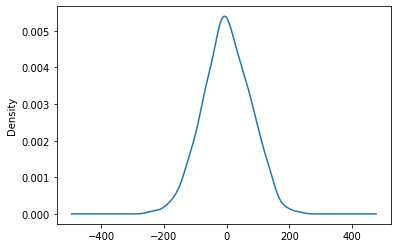

In [40]:
second_model.resid.plot.density()

Plotting the residuals of this model, it looks like we also have homoscedasticity.

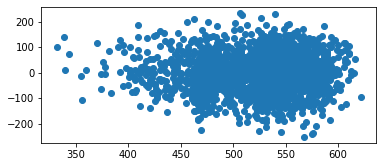

In [53]:
pred_val = second_model.fittedvalues.copy()
true_val = y_train['readingScore'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6,2.5))
plt.scatter(pred_val, residual)

Going back to our feature visualizations, we can see why it may be difficult to model this data with a linear regression model. None of our continuous variables have a linear relationship with the target variable, which is another assumption for these types of models.

In [41]:
print(second_model.params,"\n\n", second_model.pvalues)

Intercept                             331.248815
C(grade)[T.9]                          83.643385
C(grade)[T.10]                        130.339556
C(grade)[T.11]                        148.081380
C(grade)[T.12]                        116.619372
C(male)[T.1]                           -9.883069
C(expectBachelors)[T.1.0]              56.119916
C(motherHS)[T.1.0]                      9.804860
C(fatherHS)[T.1.0]                      7.435566
C(fatherWork)[T.1.0]                    5.311143
C(englishAtHome)[T.1.0]                13.385998
C(computerForSchoolwork)[T.1.0]        16.327563
C(read30MinsADay)[T.1.0]               35.043539
C(schoolHasLibrary)[T.1.0]            -16.296166
C(publicSchool)[T.1]                  -22.581419
C(urban)[T.1]                          -4.359907
C(AmericanIndianAlaskaNative)[T.1]    -65.433522
C(Asian)[T.1]                          14.917029
C(Black)[T.1]                         -53.639915
C(Hispanic)[T.1]                      -22.849947
C(White)[T.1]       

The best model we could make tells us that the variables with the biggest impact (lowest p-value, highest coefficient) are:
* `expectBachelors`
* `read30MinsADay`
* `Black`